In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)
survey

{'data':      EDUCATION SOUTH     SEX  EXPERIENCE       UNION  AGE      RACE  \
 0            8    no  female          21  not_member   35  Hispanic   
 1            9    no  female          42  not_member   57     White   
 2           12    no    male           1  not_member   19     White   
 3           12    no    male           4  not_member   22     White   
 4           12    no    male          17  not_member   35     White   
 ..         ...   ...     ...         ...         ...  ...       ...   
 529         18    no    male           5  not_member   29     White   
 530         12    no  female          33  not_member   51     Other   
 531         17    no  female          25      member   48     Other   
 532         12   yes    male          13      member   31     White   
 533         16    no    male          33  not_member   55     White   
 
        OCCUPATION         SECTOR       MARR  
 0           Other  Manufacturing    Married  
 1           Other  Manufacturin

In [5]:
X = survey.data[survey.feature_names]
X.describe(include='all')

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [6]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [7]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

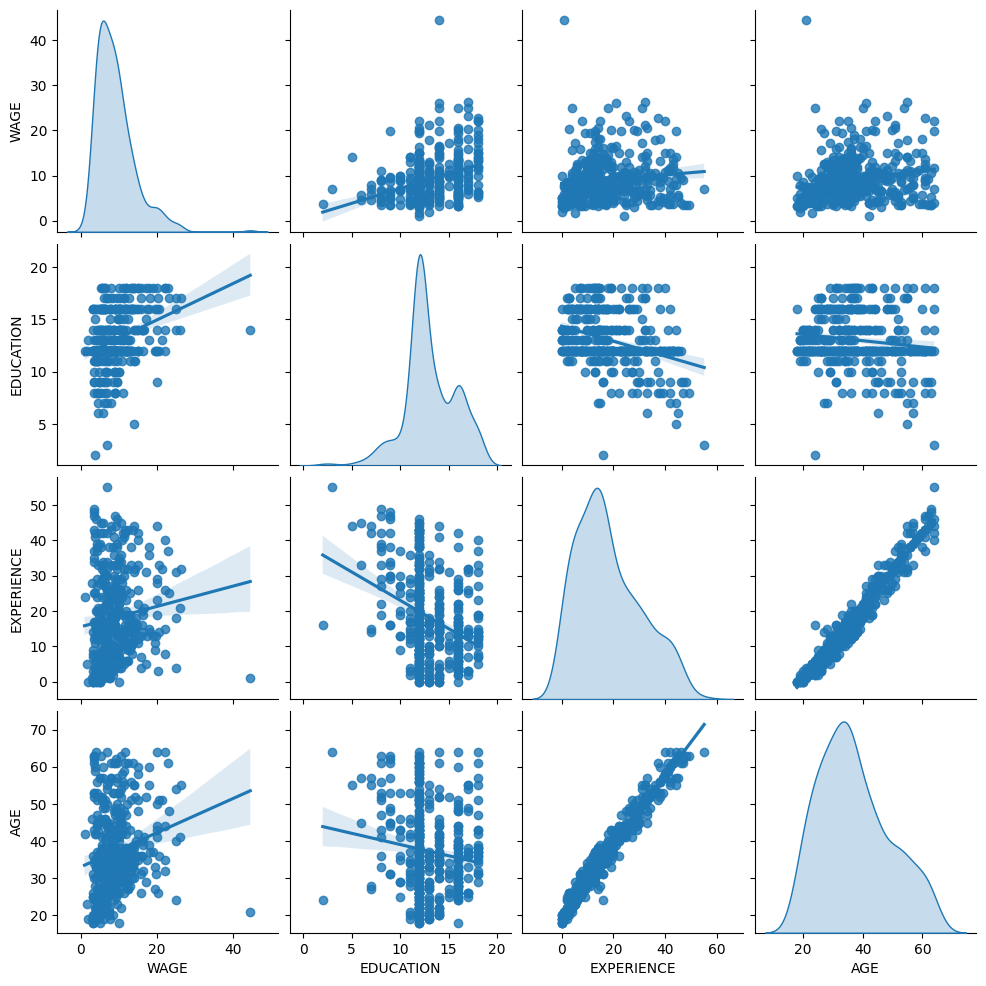

In [9]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

## The machine learning pipeline

In [10]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


To avoid categorical features to be treated as ordered values, we need to one-hot-encode them:

* __one-hot-encode__ (_generate a column by category_) the categorical columns, only for non-bonary categorical variables.
* as a first approach (we will see after how the normalisation of numerical values will affect our discussion), keep numerical values as they are.

In [11]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

To describe the dataset as a linear model we use a ridge regressor with a very small regularization and to model the logarithm of the WAGE.

In [12]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

### Processing the dataset

First, we fit the model.

In [13]:
model.fit(X_train, y_train)

/Users/gblasd/Documents/DataScience/.venv/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

To describe the dataset as a linear model we use a ridge regressor with a very small regularization and to model the logarithm of the WAGE.

In [14]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

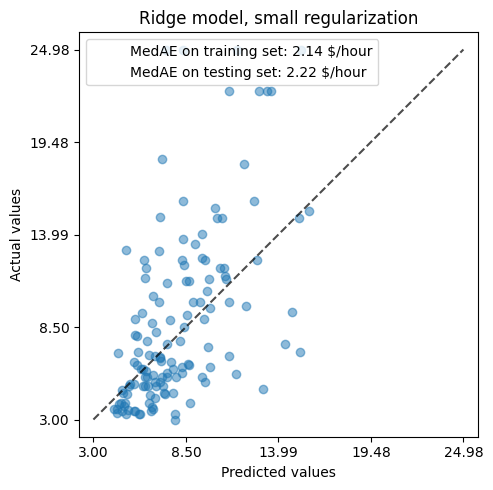

In [15]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The model learnt is far from being a good model making accurate predictions: this is obvious when looking at the plot above, where good predictions should lie on the black dashed line.

In the following section, we will interpret the coefficients of the model. While we do so, we should keep in mind that any conclusion we draw is about the model that we build, rather than about the true (real-world) generative process of the data.

# Interpreting coefficients: scale matters

In [17]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013618
RACE_Other,-0.009174
RACE_White,0.022495
OCCUPATION_Clerical,0.000281
OCCUPATION_Management,0.090764
OCCUPATION_Other,-0.024866
OCCUPATION_Professional,0.072199
OCCUPATION_Sales,-0.046400
OCCUPATION_Service,-0.090817
SECTOR_Construction,-0.000358


The AGE coefficient is expressed in “dollars/hour per living years” while the EDUCATION one is expressed in “dollars/hour per years of education”. This representation of the coefficients has the benefit of making clear the practical predictions of the model: an increase of 
 year in AGE means a decrease of 
 dollars/hour, while an increase of 
 year in EDUCATION means an increase of 
 dollars/hour. On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1. Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features have different natural scales, and hence value ranges, because of their different unit of measure. This is more visible if we plot the coefficients.

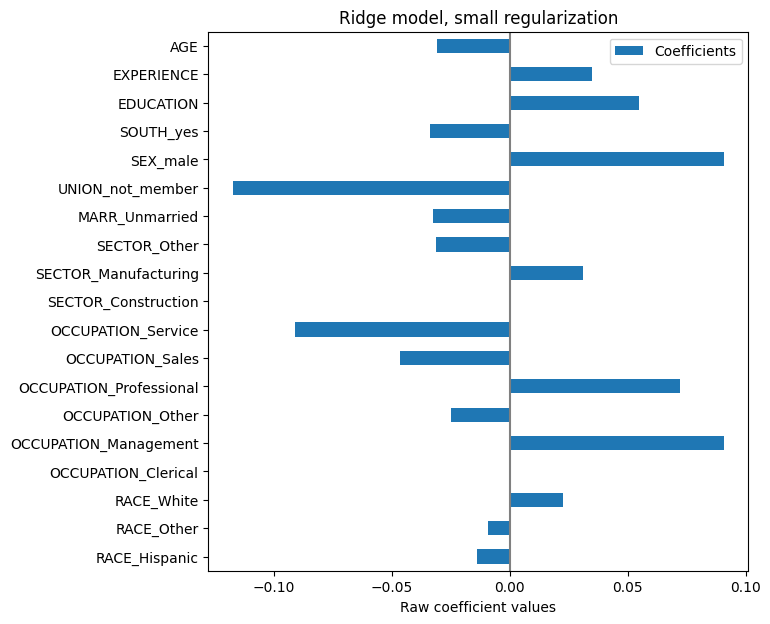

In [18]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Indeed, from the plot above the most important factor in determining WAGE appears to be the variable UNION, even if our intuition might tell us that variables like EXPERIENCE should have more impact.

Looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on a small scale, while others, like AGE, varies a lot more, several decades.

This is visible if we compare the standard deviations of different features.

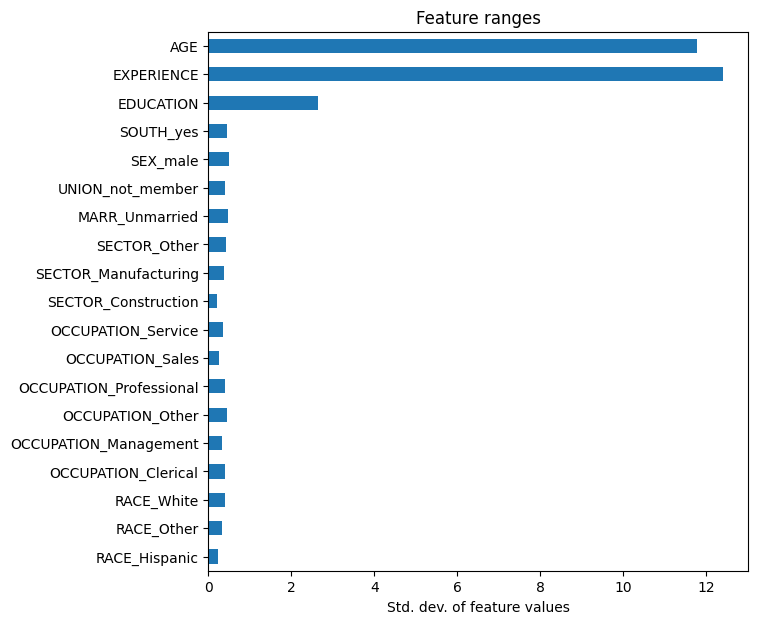

In [19]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the same unit of measure. As we will see after this is equivalent to normalize numerical variables to their standard deviation, as $y=\sum coef_i x X_i = \sum (coef_i x std_i) x (X_i/std_i)$
.

In that way, we emphasize that the greater the variance of a feature, the larger the weight of the corresponding coefficient on the output, all else being equal.

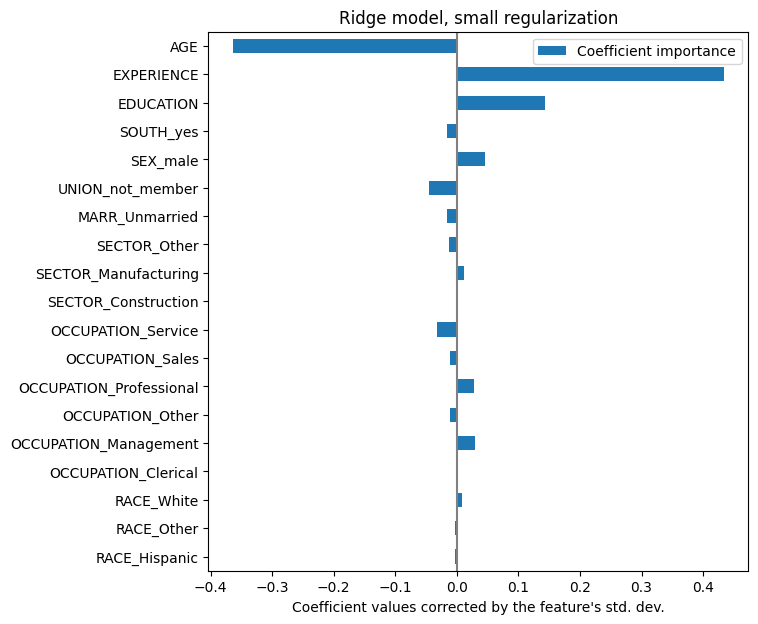

In [20]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Now that the coefficients have been scaled, we can safely compare them.

The plot above tells us about dependencies between a specific feature and the target when all other features remain constant, i.e., conditional dependencies. An increase of the AGE will induce a decrease of the WAGE when all other features remain constant. On the contrary, an increase of the EXPERIENCE will induce an increase of the WAGE when all other features remain constant. Also, AGE, EXPERIENCE and EDUCATION are the three variables that most influence the model.

# Interpreting coefficients: being cautious about causality

Linear models are a great tool for measuring statistical association, but we should be cautious when making statements about causality, after all correlation doesn’t always imply causation. This is particularly difficult in the social sciences because the variables we observe only function as proxies for the underlying causal process.

In our particular case we can think of the EDUCATION of an individual as a proxy for their professional aptitude, the real variable we’re interested in but can’t observe. We’d certainly like to think that staying in school for longer would increase technical competency, but it’s also quite possible that causality goes the other way too. That is, those who are technically competent tend to stay in school for longer.

An employer is unlikely to care which case it is (or if it’s a mix of both), as long as they remain convinced that a person with more EDUCATION is better suited for the job, they will be happy to pay out a higher WAGE.

This confounding of effects becomes problematic when thinking about some form of intervention e.g. government subsidies of university degrees or promotional material encouraging individuals to take up higher education. The usefulness of these measures could end up being overstated, especially if the degree of confounding is strong. Our model predicts a 0.054699 increase in hourly wage for each year of education. The actual causal effect might be lower because of this confounding.

# Checking the variability of the coefficients

We can check the coefficient variability through cross-validation: it is a form of data perturbation (related to resampling).

If coefficients vary significantly when changing the input dataset their robustness is not guaranteed, and they should probably be interpreted with caution.

In [21]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

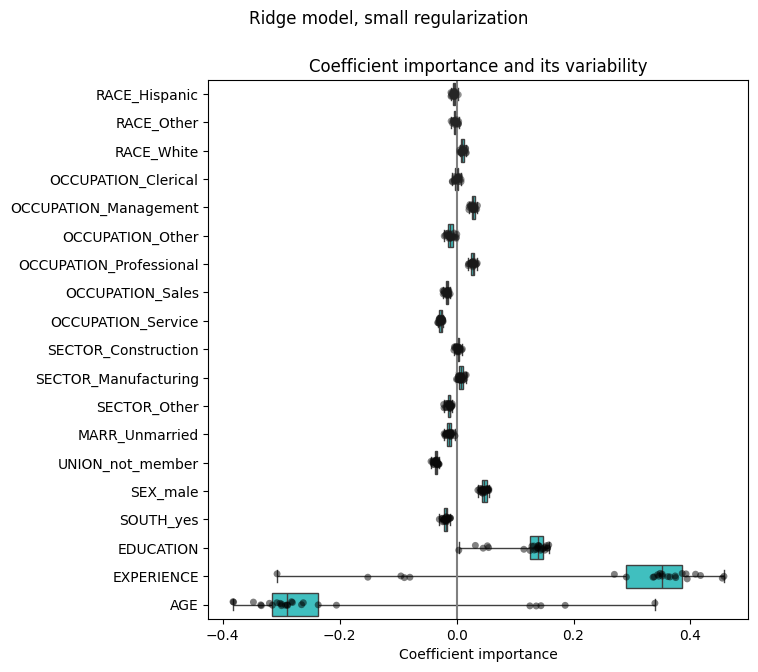

In [22]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

# The problem of correlated variables

The AGE and EXPERIENCE coefficients are affected by strong variability which might be due to the collinearity between the 2 features: as AGE and EXPERIENCE vary together in the data, their effect is difficult to tease apart.

To verify this interpretation we plot the variability of the AGE and EXPERIENCE coefficient.

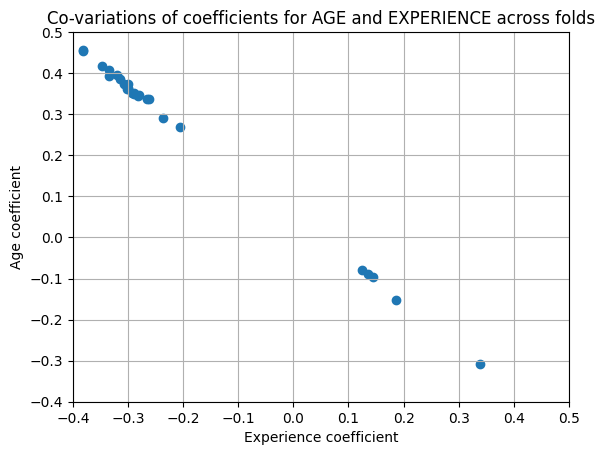

In [23]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

Two regions are populated: when the EXPERIENCE coefficient is positive the AGE one is negative and vice-versa.

To go further we remove one of the 2 features and check what is the impact on the model stability.

In [24]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_
        * est[:-1].transform(X.drop(columns=column_to_drop).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names[:-1],
)

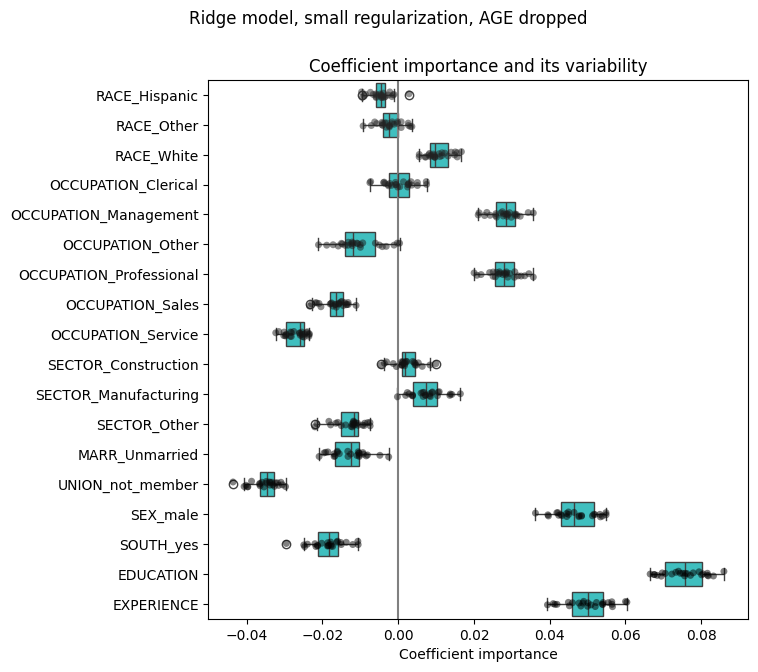

In [25]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model, small regularization, AGE dropped")
plt.subplots_adjust(left=0.3)

The estimation of the EXPERIENCE coefficient now shows a much reduced variability. EXPERIENCE remains important for all models trained during cross-validation.

# Preprocessing numerical variables

In [26]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

In [27]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

Again, we check the performance of the computed model using, for example, the median absolute error of the model and the R squared coefficient.

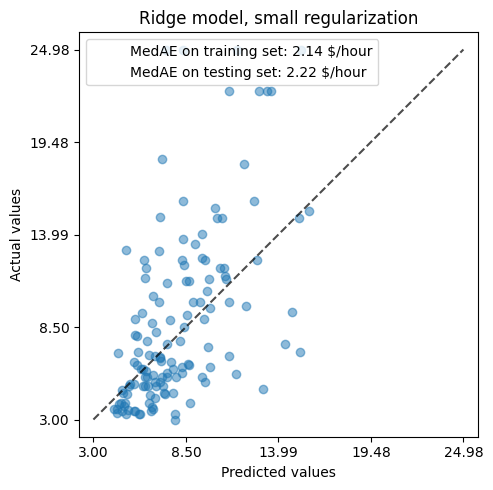

In [28]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

For the coefficient analysis, scaling is not needed this time because it was performed during the preprocessing step.

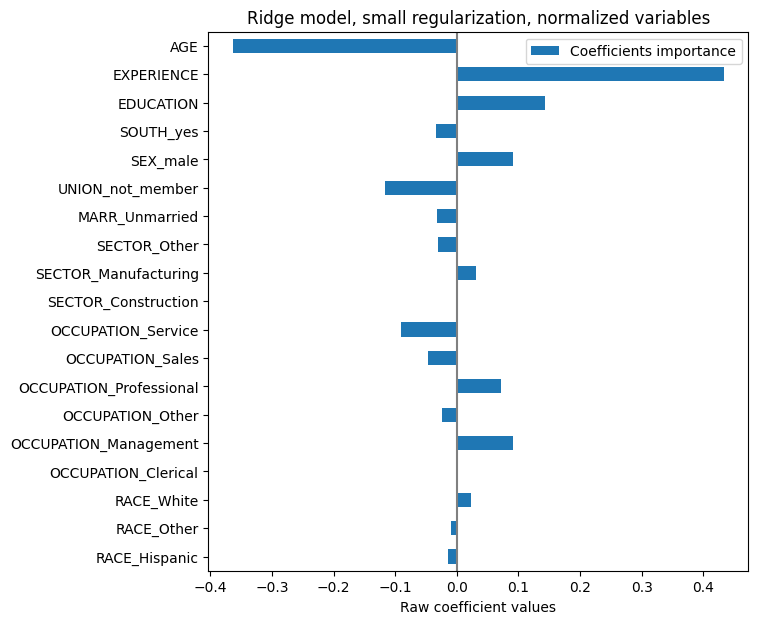

In [29]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

We now inspect the coefficients across several cross-validation folds. As in the above example, we do not need to scale the coefficients by the std. dev. of the feature values since this scaling was already done in the preprocessing step of the pipeline.

In [30]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

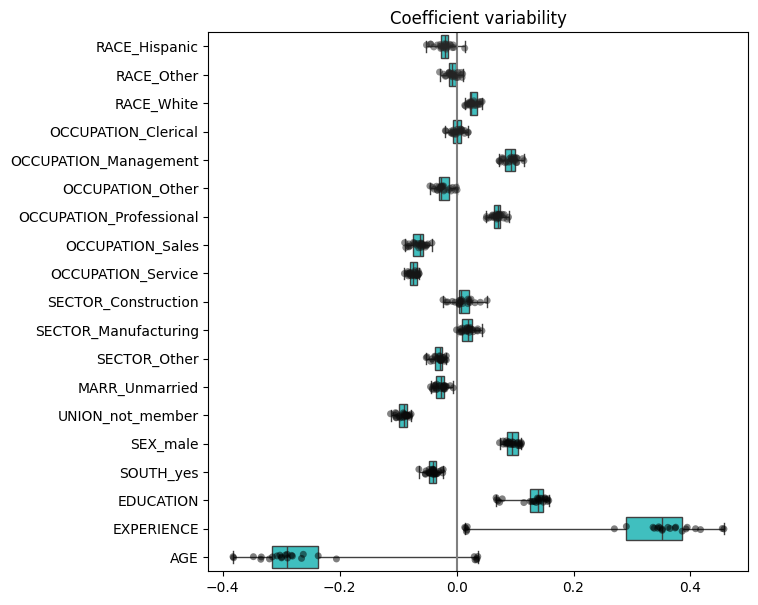

In [31]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

The result is quite similar to the non-normalized case.

ref:
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html